In [37]:
import numpy as np
import pandas as pd


df = pd.read_csv('/content/Churn_Modelling.csv')

In [38]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [40]:
from imblearn.over_sampling import SMOTE

In [41]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, precision_recall_curve)
import joblib

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [43]:
def load_and_clean_data():
    df = pd.read_csv('/content/Churn_Modelling.csv')

    # Remove unnecessary columns
    df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

    # Create new features
    df['BalanceSalaryRatio'] = df['Balance'] / (df['EstimatedSalary'] + 1)
    df['TenurePerAge'] = df['Tenure'] / (df['Age'] + 1)

    print(df.head(4))
    return df


df = load_and_clean_data()

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  BalanceSalaryRatio  \
0          1               1        101348.88       1            0.000000   
1          0               1        112542.58       0            0.744670   
2          1               0        113931.57       1            1.401362   
3          0               0         93826.63       0            0.000000   

   TenurePerAge  
0      0.046512  
1      0.023810  
2      0.186047  
3      0.025000  


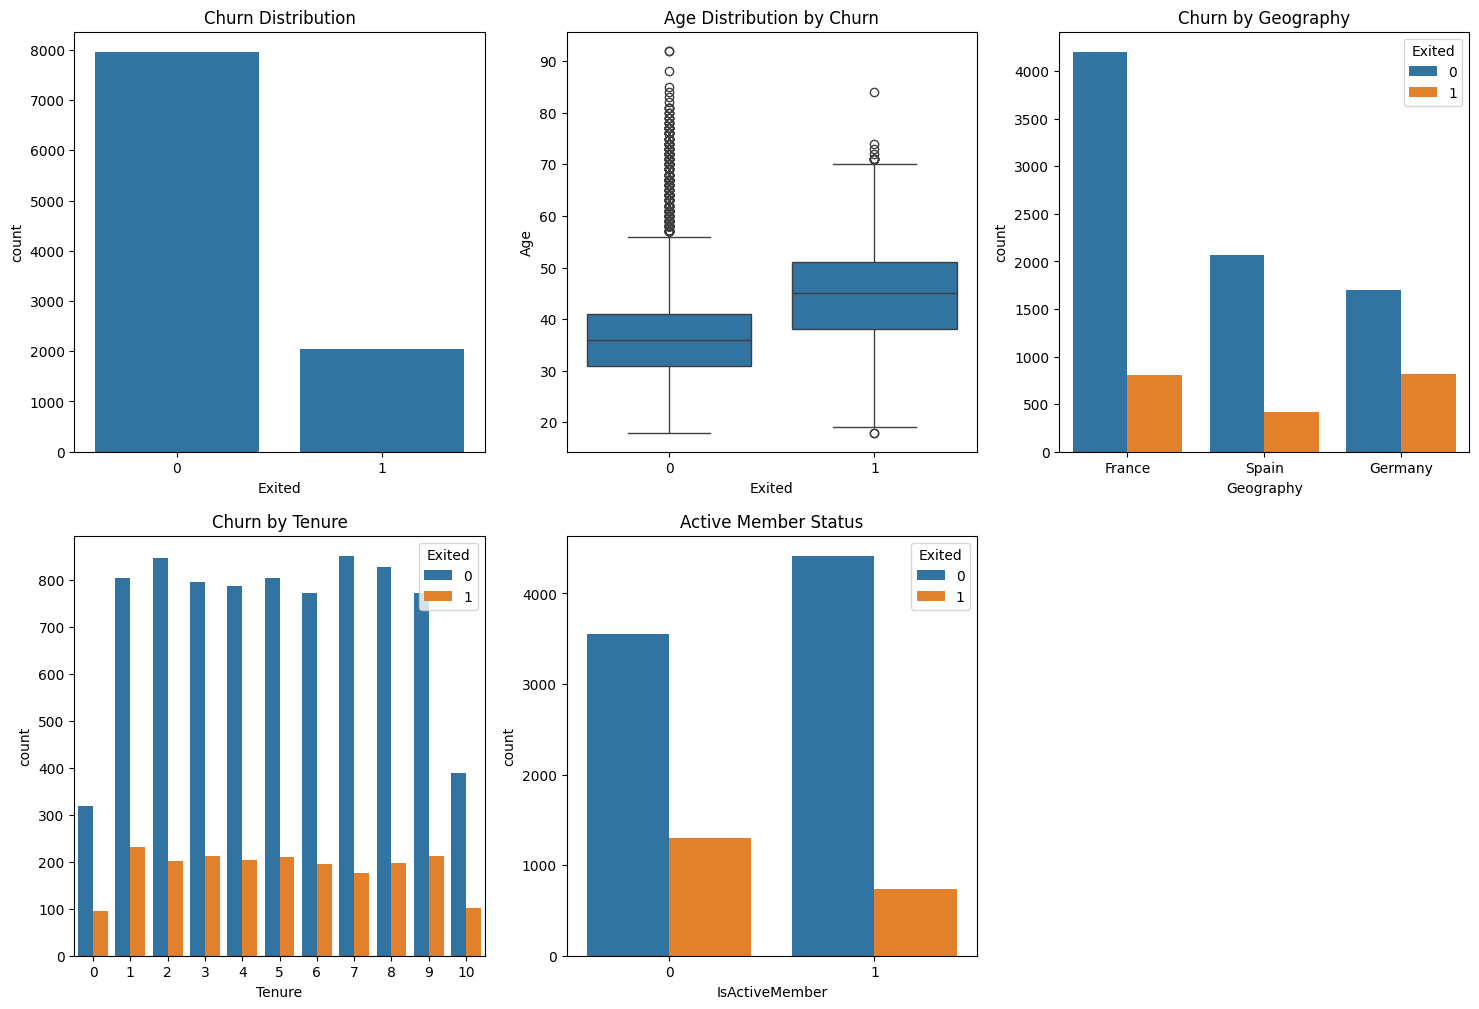

In [44]:
# 2. EDA & Visualization
# ----------------------
def perform_eda(df):
    plt.figure(figsize=(18, 12))

    # Plot 1: Churn Distribution
    plt.subplot(2,3,1)
    sns.countplot(x='Exited', data=df)
    plt.title('Churn Distribution')

    # Plot 2: Age vs Churn
    plt.subplot(2,3,2)
    sns.boxplot(x='Exited', y='Age', data=df)
    plt.title('Age Distribution by Churn')

    # Plot 3: Geography Impact
    plt.subplot(2,3,3)
    sns.countplot(x='Geography', hue='Exited', data=df)
    plt.title('Churn by Geography')
    # Plot 4: Tenure Distribution
    plt.subplot(2,3,4)
    sns.countplot(x='Tenure', hue='Exited', data=df)
    plt.title('Churn by Tenure')

    # Plot 5: Active Members
    plt.subplot(2,3,5)
    sns.countplot(x='IsActiveMember', hue='Exited', data=df)
    plt.title('Active Member Status')

    plt.show()


perform_eda(df)

In [45]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenurePerAge
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.046512
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744670,0.023810
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401362,0.186047
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025000
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587035,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0.000000,0.125000
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0.564102,0.277778
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,0.000000,0.189189
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,0.808222,0.069767


In [46]:
# 3. Data Preprocessing

def preprocess_data(df):
    # Convert categorical features
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

    # Split features and target
    X = df.drop('Exited', axis=1)
    y = df['Exited']

    # Handle class imbalance
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=0.2, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    return X_train, X_test, y_train, y_test, scaler


# Step 3: Preprocess data
X_train, X_test, y_train, y_test, scaler = preprocess_data(df)


In [47]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [48]:
# MLP Model Architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)


Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6765 - loss: 0.6005 - val_accuracy: 0.7904 - val_loss: 0.4452
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7857 - loss: 0.4687 - val_accuracy: 0.8069 - val_loss: 0.4140
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8008 - loss: 0.4412 - val_accuracy: 0.8183 - val_loss: 0.3967
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8049 - loss: 0.4353 - val_accuracy: 0.8199 - val_loss: 0.3873
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8218 - loss: 0.4057 - val_accuracy: 0.8226 - val_loss: 0.3806
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8136 - loss: 0.4074 - val_accuracy: 0.8230 - val_loss: 0.3762
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8250 - loss: 0.3931 - val_accuracy: 0.8285 - val_loss: 0.3736
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8284 - loss: 0.3915 - val_accuracy: 0.

In [61]:

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.77 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [50]:
# Evaluate model
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.88
ROC AUC: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      1633
           1       0.91      0.83      0.87      1553

    accuracy                           0.88      3186
   macro avg       0.88      0.88      0.88      3186
weighted avg       0.88      0.88      0.88      3186



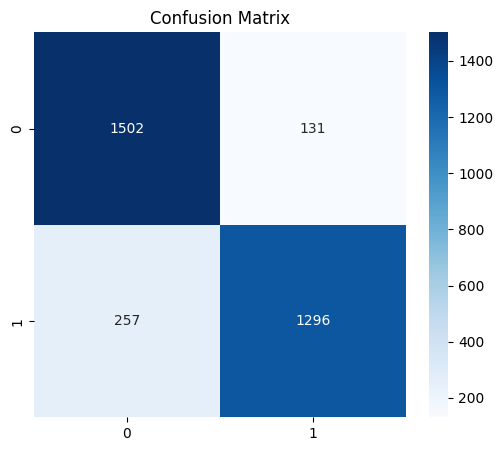

In [51]:
# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

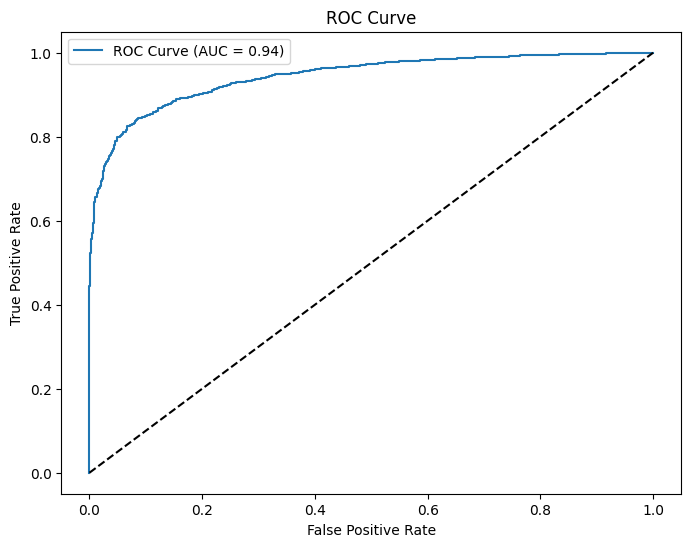

In [52]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

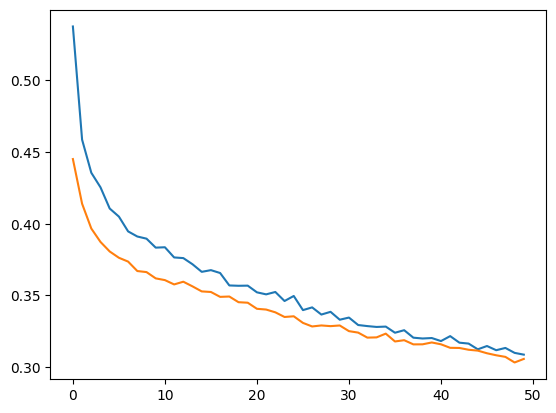

In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


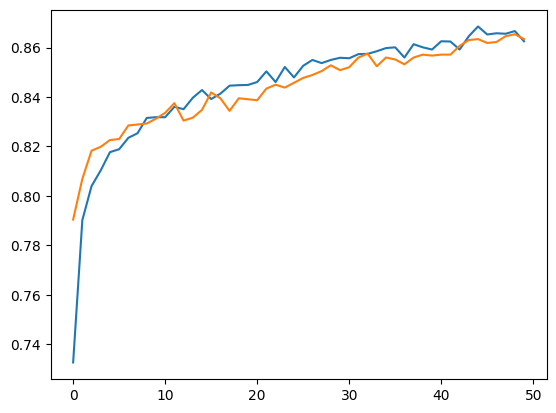

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
